# Goal

We evaluate a repopulation by looking at the correlation between repopulation values and average birds per checklist at various locations. 

We have non-uniform information on locations. 

For some locations, there are many checklists, and we can compute birds per checklist accurately. For other locations, we have only one or two checklists. 

On the other hand, locations with many checklists are often in disturbed terrain: it's terrain that is accessible to humans and often disturbed by their frequent presence (e.g., close to car access, many visitors, etc).  Further, locations are affected by "location noise" due to their own circumstances: fluctuations in nutrient density, birder access (the predominant bird-watching paths may be in various directions, and in different terrain types), birder circumstances (tourist spots vs. stations used by researchers), birder intentions (nearby bodies of water may attract birder's attention more than the surrounting forest).  So there is also location-to-location noise. 

Let: 
* Checklist noise is the noise associated with checklists at the same locations. 
* Location noise is the noise from one location to the other. 

If checklist noise is greater than location noise, we should preferentially use only locations with sufficient checklists (e.g., 10). 

If the two noises are equivalent, we should use all locations, since locations with fewer checklists may correspond to less disturbed locations. 

Here, we evaluate both kinds of noise.


## Code Setup

In [1]:
DATA_PATH = "data/CA-Final"
# You need to provide a path to the eBird database. 
DB_PATH = "/Users/luca/data/eBird/bird_data_uswest.db"

In [2]:
import os
import pandas as pd
import numpy as np
import sys

In [3]:
sys.path.append(os.path.join(os.getcwd(), "birdmaps"))

In [4]:
import ebird_db, bird_runs


In [5]:

import matplotlib.pyplot as plt


In [6]:

bird_run = bird_runs.BirdRun(DATA_PATH)

NUM_SIMULATIONS = 400


In [7]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [8]:
ebird_obs = ebird_db.EbirdObservations(DB_PATH)
max_dist = 2
date_range = ("2012-01-01", "2018-12-31")
breeding = True
bird_run = bird_runs.BirdRun(DATA_PATH)

def analyze_checklist_noise(bird, min_checklists=10):
    """Displays the observation count noise at a location."""
    bird_name = bird.name
    df = pd.read_csv(bird.obs_csv_path)
    # limit to squares where max hab > 0.9
    df = df.loc[lambda r : r["max_hab"] > 0.9]
    # and we have sufficient checklists. 
    df = df.loc[lambda r : r["NumChecklists"] >= min_checklists]
    stdevs = []
    for square in list(df["Square"]):
        checklists_df = ebird_obs.get_square_individual_checklists(
            square, bird, date_range=date_range, max_dist=max_dist)
        c = checklists_df.loc[lambda r : r["Count"] != "X"]
        stdevs.append(c["Count"].std())
    ddf = pd.DataFrame(stdevs)
    ddf.hist()
    plt.show()
    return ddf 


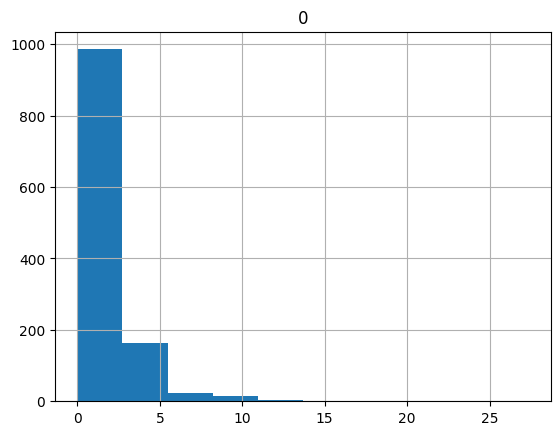

Checklist average noise acowoo: 0    1.524287
dtype: float64
Checklist median noise acowoo: 0    1.021469
dtype: float64


In [9]:
bird_acowoo = bird_run.get_bird_run("acowoo", "Acorn Woodpecker", 
                             run_name="Paper",
                             hop_distance=2, num_spreads=20, 
                             num_simulations=NUM_SIMULATIONS)
ddf = analyze_checklist_noise(bird_acowoo)
print("Checklist average noise acowoo:", ddf.mean())
print("Checklist median noise acowoo:", ddf.median())

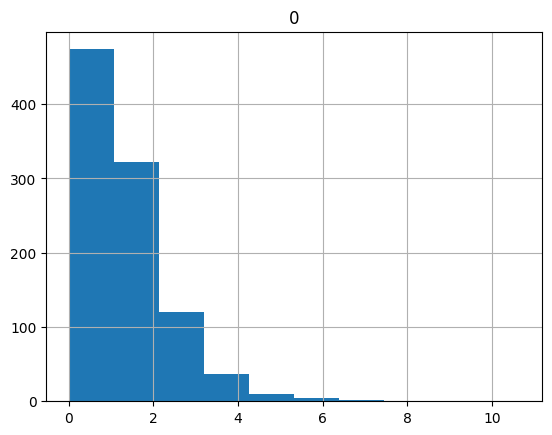

checklist average noise stejay: 0    1.291861
dtype: float64
checklist median noise stejay: 0    1.08941
dtype: float64


In [10]:
bird_stejay = bird_run.get_bird_run("stejay", "Steller's Jay", 
                             run_name="Paper",
                             hop_distance=2, num_spreads=3, 
                             num_simulations=NUM_SIMULATIONS)
ddf1 = analyze_checklist_noise(bird_stejay)
print("checklist average noise stejay:", ddf1.mean())
print("checklist median noise stejay:", ddf1.median())

In [23]:
import matplotlib.pyplot as plt
ebird_obs = ebird_db.EbirdObservations("/Users/luca/data/eBird/bird_data_uswest.db")
max_dist = 2
date_range = ("2012-01-01", "2018-12-31")
breeding = True

def analyze_location_noise(bird, min_checklists=10):
    bird_name = bird.name
    df = pd.read_csv(bird.obs_csv_path)
    # limit to squares where max hab > 0.9
    df = df.loc[lambda r : r["max_hab"] > 0.9]
    noise = []
    all_weights = []
    df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
    for num_checklists in range(1, 11):
        fdf = df.loc[lambda r : r["NumChecklists"] == num_checklists]
        stds = fdf.groupby("MaxRepopRange")["BirdRatio"].std()
        weights = fdf.groupby("MaxRepopRange")["BirdRatio"].count()
        noise.append(wmean(stds, weights))
        all_weights.append(weights.sum())
        stds.plot(label="{} checklists".format(num_checklists)) 
        plt.legend()
        plt.ylabel("Standard deviation of species sightings")
        plt.xlabel("Connectivity")
        plt.savefig("Figures/{}_location_noise.pdf".format(bird.nickname), format="pdf", bbox_inches="tight")
    plt.show()
    plt.plot(np.arange(1, 11) / 10, noise)
    plt.title("Location noise in repopulation ranges")
    plt.show()
    print("Overall location noise:", wmean(np.array(noise), np.array(all_weights)))


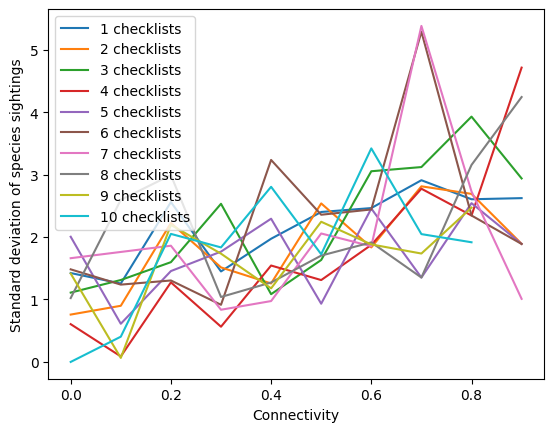

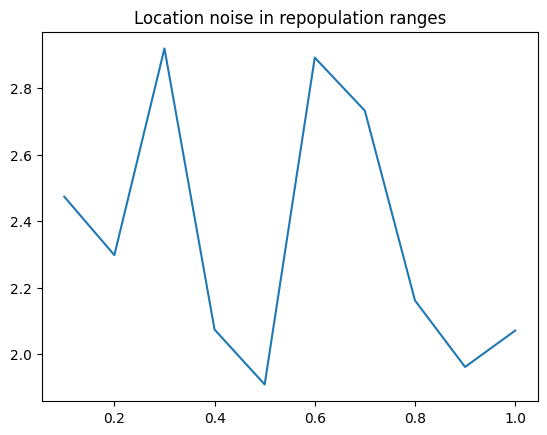

Overall location noise: 2.42320864776499


In [24]:
analyze_location_noise(bird_acowoo)

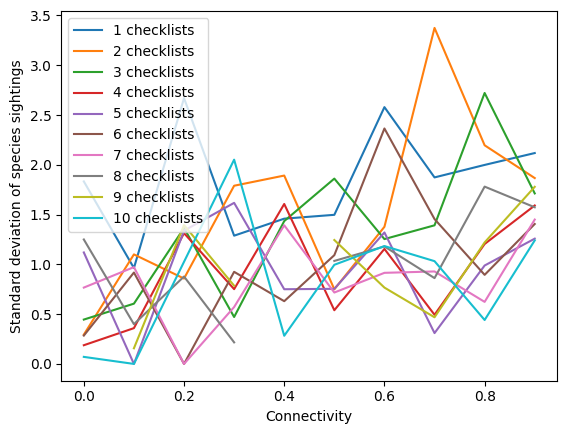

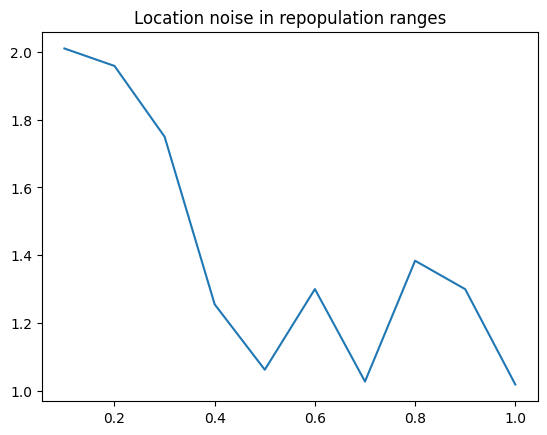

Overall location noise: 1.7710588506317


In [25]:
analyze_location_noise(bird_stejay)